# Jリーグ観客動員数を予測せよ！
- まずはデータを眺め、データ理解を目的に探索的分析とサンプルモデリングを行ってみましょう
- コンペページは[こちら](https://signate.jp/courses/VNeoDl9Mpg6YkBQL)
- 目次
    1. [ライブラリのインポート](#ライブラリのインポート)
    1. [データの読み込み](#データの読み込み)
    1. [各ファイルの行数・列数の確認](#各ファイルの行数・列数の確認)
    1. [train, condition, stadiumの先頭行を見てみる](#train,-condition,-stadiumの先頭行を見てみる)
    1. [trainの基本統計量を確認してみる](#trainの基本統計量を確認してみる)
    1. [欠損値がないか確認してみる](#欠損値がないか確認してみる)
    1. [trainの各カラムを見てみる](#trainの各カラムを見てみる)
    1. [データを絞って見てみる](#データを絞って見てみる)
    1. [折れ線グラフ（2012年のサンフレッチェ広島のホーム試合における観客動員数の推移）](#折れ線グラフ（2012年のサンフレッチェ広島のホーム試合における観客動員数の推移）)
    1. [ヒストグラム（観客動員数の分布）](#ヒストグラム（観客動員数の分布）)
    1. [箱ひげ図（曜日×観客動員数の分布）](#箱ひげ図（曜日×観客動員数の分布）)
    1. [クロス集計（J1チームの各対戦組み合わせの平均観客動員数）+ heatmap](#クロス集計（J1チームの各対戦組み合わせの平均観客動員数）+-heatmap)
    1. [簡単なモデルを作って投稿してみる](#簡単なモデルを作って投稿してみる)

### ライブラリのインポート

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams["font.family"] = "IPAexGothic" # 日本語の文字化け防止

Duplicate key in file PosixPath('/Users/niko/Desktop/MyApp/study/python/environment_3_9_7/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


### データの読み込み
- 基本データは下記の5ファイルです

In [7]:
train = pd.read_csv("data/received/train.csv")
test = pd.read_csv("data/received/test.csv")
condition = pd.read_csv("data/received/condition.csv")
stadium = pd.read_csv("data/received/stadium.csv")
sample = pd.read_csv("data/received/sample_submit.csv",header=None)

### 各ファイルの行数・列数を確認

In [8]:
train.shape

(1721, 11)

In [9]:
test.shape

(313, 10)

In [10]:
condition.shape

(2034, 31)

In [11]:
stadium.shape

(59, 3)

In [12]:
sample.shape

(313, 2)

### train, condition, stadiumの先頭行を見てみる

In [13]:
train.head()

,id,y,year,stage,match,gameday,time,home,away,stadium,tv
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＮＨＫ名古屋
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）／ＮＨＫ大阪
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,スカパー／ｅ２／スカパー光／ＮＨＫ広島
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）／ＮＨＫ札幌


In [14]:
condition.head()

,id,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,...,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11
0,13994,1,0,雨,3.8,66%,木村 博之,ベガルタ仙台,林 卓人,菅井 直樹,...,新井場 徹,岩政 大樹,中田 浩二,アレックス,青木 剛,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ
1,13995,1,0,屋内,12.4,43%,西村 雄一,名古屋グランパス,楢﨑 正剛,田中 隼磨,...,吉田 豊,岩下 敬輔,カルフィン ヨン ア ピン,李 記帝,村松 大輔,河井 陽介,枝村 匠馬,高木 俊幸,アレックス,大前 元紀
2,13996,2,3,晴一時雨,11.3,41%,高山 啓義,ガンバ大阪,藤ヶ谷 陽介,加地 亮,...,近藤 岳登,北本 久仁衛,伊野波 雅彦,相馬 崇人,三原 雅俊,田中 英雄,野沢 拓也,橋本 英郎,森岡 亮太,大久保 嘉人
3,13997,1,0,曇一時雨のち晴,11.4,52%,松尾 一,サンフレッチェ広島,西川 周作,森脇 良太,...,濱田 水輝,阿部 勇樹,槙野 智章,平川 忠亮,鈴木 啓太,山田 直輝,梅崎 司,柏木 陽介,原口 元気,田中 達也
4,13998,0,0,屋内,22.5,32%,廣瀬 格,コンサドーレ札幌,李 昊乗,高木 純平,...,駒野 友一,チョ ビョングク,藤田 義明,山本 脩斗,小林 裕紀,山本 康裕,山田 大記,松浦 拓弥,菅沼 実,前田 遼一


In [15]:
stadium.head()

,name,address,capa
0,名古屋市瑞穂陸上競技場,愛知県名古屋市瑞穂区山下通5-1,20000
1,豊田スタジアム,愛知県豊田市千石町7-2,40000
2,フクダ電子アリーナ,千葉県千葉市中央区川崎町1-20,18500
3,日立柏サッカー場,千葉県柏市日立台1-2-50,15349
4,ニンジニアスタジアム,愛媛県松山市上野町乙46,15576


### trainの基本統計量を確認してみる
- object型の基本統計量を見たい場合は、`train.describe(include=["O"])`とします

In [16]:
train.describe()

,id,y,year
count,1721.000000,1721.000000,1721.000000
mean,15045.691458,10662.395119,2012.815224
std,648.205749,8106.877159,0.757613
min,13994.000000,0.000000,2012.000000
25%,14474.000000,4750.000000,2012.000000
50%,15044.000000,8650.000000,2013.000000
75%,15528.000000,13431.000000,2013.000000
max,16237.000000,54905.000000,2014.000000


In [17]:
# 観客ゼロってなんだろ
train[train['y']==0]

,id,y,year,stage,match,gameday,time,home,away,stadium,tv
1385,15699,0,2014,Ｊ１,第４節第１日,03/23(日),15:04,浦和レッズ,清水エスパルス,埼玉スタジアム２００２,スカパー！／スカパー！プレミアムサービス／テレ玉


### 欠損値がないか確認してみる

In [18]:
train.isnull().sum()

id         0
y          0
year       0
stage      0
match      0
gameday    0
time       0
home       0
away       0
stadium    0
tv         0
dtype: int64

### データの抽出まとめ(各カラムを見てみる時)

In [19]:
# 抽出まとめ
train["year"].value_counts()
train['gameday'].apply(lambda x: x[6:7]).value_counts()
set(train[train['stage']=='Ｊ１']['home'].unique()) & set(train[train['stage']=='Ｊ２']['home'].unique())
print('2012年のチーム数：', train[train['year']==2012]['home'].nunique())
train.groupby('home')['stadium'].unique()
condition.loc[:,'home_01':'away_11'].stack().value_counts()
train[train["home"]=="サガン鳥栖"]
train["y"].mean()
train[train["home"]=="サガン鳥栖"]["y"].mean()
train[(train["home"]=="サガン鳥栖")&(train["year"]==2012)]
train[train["year"]==2012]["y"].mean()
train[(train["home"]=="サガン鳥栖")&(train["year"]==2012)]["y"].mean()



2012年のチーム数： 40


12271.866666666667

### trainの各カラムを見てみる

In [20]:
train["year"].value_counts()

2012    682
2013    675
2014    364
Name: year, dtype: int64

In [21]:
train["stage"].value_counts()

Ｊ２    1046
Ｊ１     675
Name: stage, dtype: int64

In [22]:
train['gameday'].apply(lambda x: x[6:7]).value_counts()

土    733
日    711
水    124
金     46
月     43
火     42
木     22
Name: gameday, dtype: int64

In [23]:
train["time"].value_counts()

19:04    254
19:03    166
13:04    148
13:03    121
16:04    118
        ... 
13:08      1
17:35      1
14:34      1
14:36      1
15:01      1
Name: time, Length: 63, dtype: int64

In [24]:
train["home"].value_counts()

愛媛ＦＣ           51
ロアッソ熊本         51
栃木ＳＣ           50
モンテディオ山形       49
松本山雅ＦＣ         49
ＦＣ岐阜           48
アビスパ福岡         48
徳島ヴォルティス       48
ジェフユナイテッド千葉    47
水戸ホーリーホック      47
ファジアーノ岡山       47
京都サンガF.C.      46
コンサドーレ札幌       46
湘南ベルマーレ        46
横浜ＦＣ           45
カターレ富山         45
東京ヴェルディ        44
大分トリニータ        43
ギラヴァンツ北九州      43
ジュビロ磐田         43
ヴァンフォーレ甲府      42
ヴィッセル神戸        41
柏レイソル          41
浦和レッズ          40
ガンバ大阪          40
ベガルタ仙台         39
清水エスパルス        39
セレッソ大阪         39
川崎フロンターレ       39
ＦＣ東京           38
サンフレッチェ広島      37
アルビレックス新潟      37
横浜Ｆ・マリノス       36
大宮アルディージャ      36
サガン鳥栖          36
鹿島アントラーズ       36
名古屋グランパス       35
ガイナーレ鳥取        35
ザスパクサツ群馬       28
Ｖ・ファーレン長崎      27
ＦＣ町田ゼルビア       18
ザスパ草津          17
カマタマーレ讃岐        9
Name: home, dtype: int64

In [25]:
# stageがJ1のhome列の値をset 同じくj2も
set(train[train['stage']=='Ｊ１']['home'].unique()) & set(train[train['stage']=='Ｊ２']['home'].unique())

{'ガンバ大阪',
 'コンサドーレ札幌',
 'ジュビロ磐田',
 'ヴァンフォーレ甲府',
 'ヴィッセル神戸',
 '大分トリニータ',
 '徳島ヴォルティス',
 '湘南ベルマーレ'}

In [26]:
print('2012年のチーム数：', train[train['year']==2012]['home'].nunique())
print('2013年のチーム数：', train[train['year']==2013]['home'].nunique())
print('2014年のチーム数：', train[train['year']==2014]['home'].nunique())

2012年のチーム数： 40
2013年のチーム数： 40
2014年のチーム数： 40


In [27]:
train["stadium"].value_counts()

味の素スタジアム                     64
ニンジニアスタジアム                   51
栃木県グリーンスタジアム                 50
松本平広域公園総合球技場                 49
ニッパツ三ツ沢球技場                   49
ＮＤソフトスタジアム山形                 49
鳴門・大塚スポーツパーク　ポカリスエットスタジアム    48
レベルファイブスタジアム                 48
フクダ電子アリーナ                    47
ケーズデンキスタジアム水戸                47
Ｓｈｏｎａｎ　ＢＭＷスタジアム平塚            46
シティライトスタジアム                  46
正田醤油スタジアム群馬                  45
うまかな・よかなスタジアム                45
富山県総合運動公園陸上競技場               45
岐阜メモリアルセンター長良川競技場            45
京都市西京極総合運動公園陸上競技場兼球技場        44
北九州市立本城陸上競技場                 43
大分銀行ドーム                      43
埼玉スタジアム２００２                  40
ヤマハスタジアム（磐田）                 40
万博記念競技場                      40
ノエビアスタジアム神戸                  39
等々力陸上競技場                     39
山梨中銀スタジアム                    39
ユアテックスタジアム仙台                 38
ＩＡＩスタジアム日本平                  37
日立柏サッカー場                     37
デンカビッグスワンスタジアム               37
エディオンスタジアム広島                 37
県立カシマサッカースタジアム               36
ＮＡＣＫ５スタジ

In [28]:
train.groupby('home')['stadium'].unique()

home
アビスパ福岡                                            [レベルファイブスタジアム]
アルビレックス新潟                                       [デンカビッグスワンスタジアム]
カターレ富山                                          [富山県総合運動公園陸上競技場]
カマタマーレ讃岐                                             [香川県立丸亀競技場]
ガイナーレ鳥取                                           [とりぎんバードスタジアム]
ガンバ大阪                                                  [万博記念競技場]
ギラヴァンツ北九州                                         [北九州市立本城陸上競技場]
コンサドーレ札幌                                      [札幌ドーム, 札幌厚別公園競技場]
サガン鳥栖                             [ベストアメニティスタジアム, 佐賀県総合運動場陸上競技場]
サンフレッチェ広島                                         [エディオンスタジアム広島]
ザスパクサツ群馬                                           [正田醤油スタジアム群馬]
ザスパ草津                                              [正田醤油スタジアム群馬]
ジェフユナイテッド千葉                                          [フクダ電子アリーナ]
ジュビロ磐田                                  [ヤマハスタジアム（磐田）, エコパスタジアム]
セレッソ大阪                                 [ヤンマースタジアム長居, キンチョウスタジアム]
ファジアーノ岡山            

In [29]:
train.groupby('stadium')['home'].unique()

stadium
うまかな・よかなスタジアム                                         [ロアッソ熊本]
とりぎんバードスタジアム                                         [ガイナーレ鳥取]
エコパスタジアム                                     [ジュビロ磐田, 清水エスパルス]
エディオンスタジアム広島                                       [サンフレッチェ広島]
キンチョウスタジアム                                            [セレッソ大阪]
ケーズデンキスタジアム水戸                                      [水戸ホーリーホック]
シティライトスタジアム                                         [ファジアーノ岡山]
デンカビッグスワンスタジアム                                     [アルビレックス新潟]
ニッパツ三ツ沢球技場                                    [横浜Ｆ・マリノス, 横浜ＦＣ]
ニンジニアスタジアム                                              [愛媛ＦＣ]
ノエビアスタジアム神戸                                          [ヴィッセル神戸]
フクダ電子アリーナ                                        [ジェフユナイテッド千葉]
ベストアメニティスタジアム                                          [サガン鳥栖]
ヤマハスタジアム（磐田）                                          [ジュビロ磐田]
ヤンマースタジアム長居                                           [セレッソ大阪]
ユアテックスタジアム仙台                                   

In [30]:
train["tv"].value_counts()

スカパー！／スカパー！プレミアムサービス              806
スカパー／ｅ２／スカパー光                     339
スカパー！／スカパー！プレミアムサービス／ＮＨＫ　ＢＳ１       47
スカパー／ｅ２／スカパー光／ＮＨＫ　ＢＳ１              26
スカパー！／スカパー！プレミアムサービス／とちぎテレビ（録）     17
                                 ... 
スカパー／ｅ２／スカパー光（Ｊ　ＳＰＯＲＴＳ　１）／中国放送      1
スカパー／ｅ２／スカパー光／日本海テレビ                1
スカパー／ｅ２／スカパー光／ＮＨＫ水戸                 1
スカパー／ｅ２／スカパー光／テレビ愛媛（録）              1
スカパー！／スカパー！プレミアムサービス／岡山放送（録）        1
Name: tv, Length: 210, dtype: int64

### conditionの各カラムを見てみる

In [31]:
condition['weather'].value_counts()

晴           1002
曇            499
雨            192
屋内            59
曇のち雨          46
雨のち曇          44
晴のち曇          38
曇のち晴          27
曇時々雨          25
晴時々曇          22
曇一時雨          20
曇時々晴          16
晴のち雨           9
晴一時雨           7
雨のち晴           4
雨時々曇           4
晴一時曇           2
晴時々雨           2
雪のち雨           1
雨のち曇一時雨        1
晴のち雪           1
曇時々晴一時雨        1
曇一時晴           1
曇一時晴一時雨        1
曇のち雷雨          1
曇一時雷雨のち曇       1
雨のち曇時々晴        1
晴のち曇時々雨        1
曇時々雨のち晴        1
雨時々晴           1
晴時々雪           1
晴のち曇一時雨        1
曇一時雨のち晴        1
曇のち雪           1
Name: weather, dtype: int64

In [32]:
condition.loc[:,'home_01':'away_11'].stack().value_counts()

秋元　陽太    116
飯田　真輝    111
南　雄太     110
片山　奨典    109
船山　貴之    107
        ... 
佐藤　和樹      1
窪田　良       1
三吉　聖王      1
内山　俊彦      1
野田　裕喜      1
Length: 1366, dtype: int64

### データを絞って見てみる

In [33]:
train[train["home"]=="サガン鳥栖"]

,id,y,year,stage,match,gameday,time,home,away,stadium,tv
5,13999,11283,2012,Ｊ１,第１節第１日,03/10(土),14:05,サガン鳥栖,セレッソ大阪,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光／ＮＨＫ佐賀
21,14016,10611,2012,Ｊ１,第３節第１日,03/24(土),15:04,サガン鳥栖,横浜Ｆ・マリノス,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）
32,14029,7719,2012,Ｊ１,第４節第１日,03/31(土),19:04,サガン鳥栖,ヴィッセル神戸,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光／ＮＨＫ ＢＳ１
48,14045,9735,2012,Ｊ１,第６節第１日,04/14(土),18:34,サガン鳥栖,サンフレッチェ広島,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光
56,14053,5432,2012,Ｊ１,第７節第１日,04/21(土),17:05,サガン鳥栖,アルビレックス新潟,佐賀県総合運動場陸上競技場,スカパー／ｅ２／スカパー光
73,14070,18113,2012,Ｊ１,第９節第１日,05/03(木・祝),16:04,サガン鳥栖,ベガルタ仙台,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）
117,14119,9603,2012,Ｊ１,第１４節第１日,06/16(土),19:04,サガン鳥栖,川崎フロンターレ,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光
134,14137,10345,2012,Ｊ１,第１６節第１日,06/30(土),19:03,サガン鳥栖,コンサドーレ札幌,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）
150,14155,13891,2012,Ｊ１,第１８節第１日,07/14(土),19:04,サガン鳥栖,ＦＣ東京,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光
168,14173,12844,2012,Ｊ１,第２０節第１日,08/04(土),19:04,サガン鳥栖,鹿島アントラーズ,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光


In [34]:
train["y"].mean()

10662.395119116793

In [35]:
train[train["home"]=="サガン鳥栖"]["y"].mean()

12654.138888888889

In [36]:
train[(train["home"]=="サガン鳥栖")&(train["year"]==2012)]

,id,y,year,stage,match,gameday,time,home,away,stadium,tv
5,13999,11283,2012,Ｊ１,第１節第１日,03/10(土),14:05,サガン鳥栖,セレッソ大阪,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光／ＮＨＫ佐賀
21,14016,10611,2012,Ｊ１,第３節第１日,03/24(土),15:04,サガン鳥栖,横浜Ｆ・マリノス,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）
32,14029,7719,2012,Ｊ１,第４節第１日,03/31(土),19:04,サガン鳥栖,ヴィッセル神戸,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光／ＮＨＫ ＢＳ１
48,14045,9735,2012,Ｊ１,第６節第１日,04/14(土),18:34,サガン鳥栖,サンフレッチェ広島,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光
56,14053,5432,2012,Ｊ１,第７節第１日,04/21(土),17:05,サガン鳥栖,アルビレックス新潟,佐賀県総合運動場陸上競技場,スカパー／ｅ２／スカパー光
73,14070,18113,2012,Ｊ１,第９節第１日,05/03(木・祝),16:04,サガン鳥栖,ベガルタ仙台,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）
117,14119,9603,2012,Ｊ１,第１４節第１日,06/16(土),19:04,サガン鳥栖,川崎フロンターレ,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光
134,14137,10345,2012,Ｊ１,第１６節第１日,06/30(土),19:03,サガン鳥栖,コンサドーレ札幌,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）
150,14155,13891,2012,Ｊ１,第１８節第１日,07/14(土),19:04,サガン鳥栖,ＦＣ東京,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光
168,14173,12844,2012,Ｊ１,第２０節第１日,08/04(土),19:04,サガン鳥栖,鹿島アントラーズ,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光


In [37]:
train[train["year"]==2012]["y"].mean()

10535.636363636364

In [38]:
train[(train["home"]=="サガン鳥栖")&(train["year"]==2012)]["y"].mean()

12271.866666666667

### グラフを使って可視化してみる
- 折れ線グラフ
- 棒グラフ
- ヒストグラム
- 箱ひげ図
- クロス集計 + ヒートマップ

#### 折れ線グラフ（2012年のサガン鳥栖のホーム試合における観客動員数の推移）
    - pandasではplot関数、seabornではlineplot関数を使う

In [39]:
dat = train[(train["home"]=="サガン鳥栖")&(train["year"]==2012)].reset_index(drop=True) # indexがとびとびになるので、0,1,2になるようにリセット
dat

,id,y,year,stage,match,gameday,time,home,away,stadium,tv
0,13999,11283,2012,Ｊ１,第１節第１日,03/10(土),14:05,サガン鳥栖,セレッソ大阪,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光／ＮＨＫ佐賀
1,14016,10611,2012,Ｊ１,第３節第１日,03/24(土),15:04,サガン鳥栖,横浜Ｆ・マリノス,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）
2,14029,7719,2012,Ｊ１,第４節第１日,03/31(土),19:04,サガン鳥栖,ヴィッセル神戸,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光／ＮＨＫ ＢＳ１
3,14045,9735,2012,Ｊ１,第６節第１日,04/14(土),18:34,サガン鳥栖,サンフレッチェ広島,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光
4,14053,5432,2012,Ｊ１,第７節第１日,04/21(土),17:05,サガン鳥栖,アルビレックス新潟,佐賀県総合運動場陸上競技場,スカパー／ｅ２／スカパー光
5,14070,18113,2012,Ｊ１,第９節第１日,05/03(木・祝),16:04,サガン鳥栖,ベガルタ仙台,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）
6,14119,9603,2012,Ｊ１,第１４節第１日,06/16(土),19:04,サガン鳥栖,川崎フロンターレ,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光
7,14137,10345,2012,Ｊ１,第１６節第１日,06/30(土),19:03,サガン鳥栖,コンサドーレ札幌,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）
8,14155,13891,2012,Ｊ１,第１８節第１日,07/14(土),19:04,サガン鳥栖,ＦＣ東京,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光
9,14173,12844,2012,Ｊ１,第２０節第１日,08/04(土),19:04,サガン鳥栖,鹿島アントラーズ,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光


<AxesSubplot:>

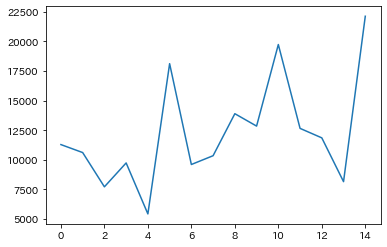

In [40]:
dat["y"].plot()

- seabornというライブラリを使うとより綺麗に可視化できます
- matplotlibのラッパーでseabornをimportしますと、フォーマットがseabornになってしまう点のみご注意下さい
- 詳しくは[こちら](http://seaborn.pydata.org/)

#### 棒グラフ（スタジアム毎のcapaの違い）
    - pandasではplot.bar関数、seabornではbarplot関数を使う

<AxesSubplot:xlabel='name'>

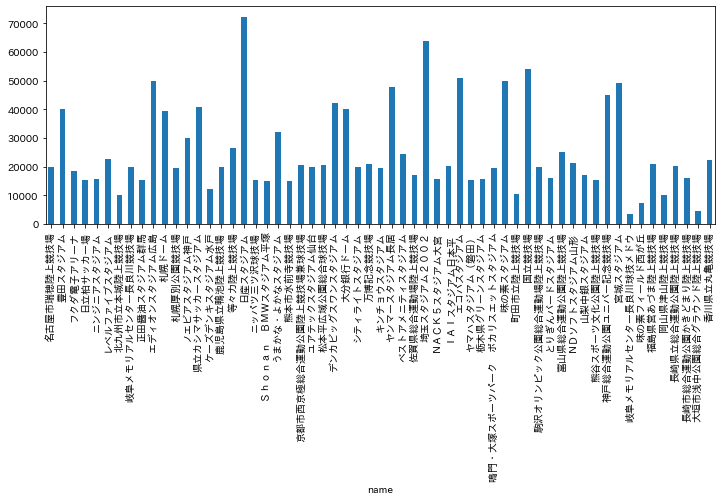

In [41]:
stadium.index = stadium["name"]
plt.tight_layout()
stadium["capa"].plot.bar(figsize=(12,4))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58]),
 [Text(0, 0, '名古屋市瑞穂陸上競技場'),
  Text(1, 0, '豊田スタジアム'),
  Text(2, 0, 'フクダ電子アリーナ'),
  Text(3, 0, '日立柏サッカー場'),
  Text(4, 0, 'ニンジニアスタジアム'),
  Text(5, 0, 'レベルファイブスタジアム'),
  Text(6, 0, '北九州市立本城陸上競技場'),
  Text(7, 0, '岐阜メモリアルセンター長良川競技場'),
  Text(8, 0, '正田醤油スタジアム群馬'),
  Text(9, 0, 'エディオンスタジアム広島'),
  Text(10, 0, '札幌ドーム'),
  Text(11, 0, '札幌厚別公園競技場'),
  Text(12, 0, 'ノエビアスタジアム神戸'),
  Text(13, 0, '県立カシマサッカースタジアム'),
  Text(14, 0, 'ケーズデンキスタジアム水戸'),
  Text(15, 0, '鹿児島県立鴨池陸上競技場 '),
  Text(16, 0, '等々力陸上競技場'),
  Text(17, 0, '日産スタジアム'),
  Text(18, 0, 'ニッパツ三ツ沢球技場'),
  Text(19, 0, 'Ｓｈｏｎａｎ\u3000ＢＭＷスタジアム平塚'),
  Text(20, 0, 'うまかな・よかなスタジアム'),
  Text(21, 0, '熊本市水前寺競技場'),
  Text(22, 0, '京都市西京極総合運動公園陸上競技場兼球技場'),
  Text(23, 0, 'ユアテックスタジアム仙台'),
  Text(2

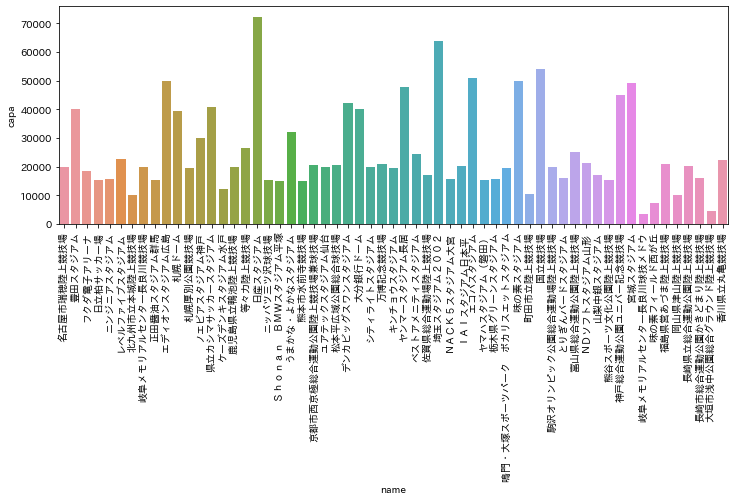

In [42]:
plt.figure(figsize=(12,4))
sns.barplot(x=stadium.index, y="capa", data=stadium)
plt.xticks(rotation=90) # x軸の名前を90度回転させて縦に表示

#### ヒストグラム（観客動員数の分布）
- pandasではplot.hist関数、seabornではhistplot関数を使う

<AxesSubplot:title={'center':'観客動員数の分布'}, ylabel='Frequency'>

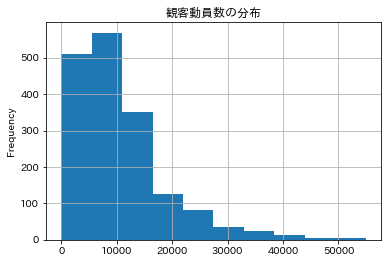

In [43]:
train["y"].plot.hist(grid=True,title="観客動員数の分布")

<AxesSubplot:title={'center':'点数の分布'}, ylabel='Frequency'>

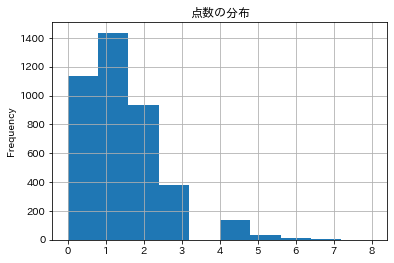

In [44]:
pd.concat([condition['home_score'], condition['away_score']]).plot.hist(grid=True, title='点数の分布')

#### 箱ひげ図（曜日×観客動員数の分布）
    - boxplot関数を使う

In [45]:
tmp = train[["y", "gameday"]].copy()
# 文字列を分割して上手く抽出
tmp["dayofweek"] = tmp["gameday"].apply(lambda x : x[x.find("(")+1:x.find("(")+2])
# 正規表現を使って抽出
tmp["dayofweek2"] = tmp["gameday"].str.extract("(月|火|水|木|金|土|日)")
tmp

,y,gameday,dayofweek,dayofweek2
0,18250,03/10(土),土,土
1,24316,03/10(土),土,土
2,17066,03/10(土),土,土
3,29603,03/10(土),土,土
4,25353,03/10(土),土,土
...,...,...,...,...
1716,3756,07/30(水),水,水
1717,7842,07/30(水),水,水
1718,5212,07/30(水),水,水
1719,3883,07/30(水),水,水


- 軸の出力を指定の順番にする、apply関数、無名関数、map関数

- 曜日の順序を揃える為に、曜日に番号を振り、その番号でソートする
    1. 曜日に対応する辞書を作る
    1. 辞書を利用し、曜日に該当する番号を新しい列「order」として生成
        - apply関数 + 無名関数(lambda)の使い方を覚えておくと値の加工に便利
        - map()の場合、引数に辞書を指定すると要素の置換になるので便利
    1. 列「order」でソート

In [46]:
order = {"月":0, "火":1, "水":2, "木":3, "金":4, "土":5, "日":6}
# map()の場合
tmp["order"] = tmp["dayofweek"].map(order)
# apply(lambda)の場合
tmp["order2"] = tmp["dayofweek"].apply(lambda x: order[x])

tmp = tmp.sort_values(by="order")
tmp

,y,gameday,dayofweek,dayofweek2,order,order2
606,10241,09/17(月・祝),月,月,0,0
377,10070,04/30(月・休),月,月,0,0
376,12154,04/30(月・休),月,月,0,0
375,3520,04/30(月・休),月,月,0,0
374,12595,04/30(月・休),月,月,0,0
...,...,...,...,...,...,...
287,4286,03/11(日),日,日,6,6
286,4148,03/11(日),日,日,6,6
285,2601,03/11(日),日,日,6,6
1221,12449,08/18(日),日,日,6,6


<AxesSubplot:xlabel='dayofweek', ylabel='y'>

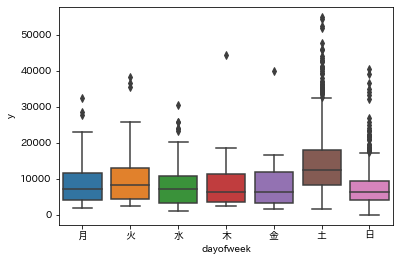

In [47]:
sns.boxplot(x="dayofweek", y="y", data=tmp)

<AxesSubplot:xlabel='month', ylabel='y'>

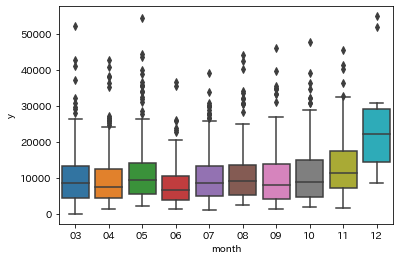

In [48]:
tmp = train.copy()
tmp['month'] = tmp['gameday'].apply(lambda x: x[:2])
sns.boxplot(x="month", y="y", data=tmp)

#### heatmap + クロス集計（J1チームの各対戦組み合わせの平均観客動員数）
    - J1が全角の「Ｊ１」なので注意
    - pivot_table関数を使う

In [49]:
tmp = train[train["stage"]=="Ｊ１"]
tmp

,id,y,year,stage,match,gameday,time,home,away,stadium,tv
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＮＨＫ名古屋
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）／ＮＨＫ大阪
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,スカパー／ｅ２／スカパー光／ＮＨＫ広島
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）／ＮＨＫ札幌
...,...,...,...,...,...,...,...,...,...,...,...
1484,15816,19254,2014,Ｊ１,第１７節第１日,07/27(日),19:03,川崎フロンターレ,アルビレックス新潟,等々力陸上競技場,スカパー！／スカパー！プレミアムサービス
1485,15817,11095,2014,Ｊ１,第１７節第１日,07/27(日),18:04,清水エスパルス,柏レイソル,ＩＡＩスタジアム日本平,スカパー！／スカパー！プレミアムサービス
1486,15819,13431,2014,Ｊ１,第１７節第１日,07/27(日),19:04,セレッソ大阪,サガン鳥栖,キンチョウスタジアム,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１
1487,15820,18012,2014,Ｊ１,第１７節第１日,07/27(日),19:04,ヴィッセル神戸,ガンバ大阪,ノエビアスタジアム神戸,スカパー！／スカパー！プレミアムサービス


In [50]:
cb = pd.pivot_table(tmp, index="home", columns="away", values="y")
cb

away,アルビレックス新潟,ガンバ大阪,コンサドーレ札幌,サガン鳥栖,サンフレッチェ広島,ジュビロ磐田,セレッソ大阪,ベガルタ仙台,ヴァンフォーレ甲府,ヴィッセル神戸,...,大宮アルディージャ,川崎フロンターレ,徳島ヴォルティス,柏レイソル,横浜Ｆ・マリノス,浦和レッズ,清水エスパルス,湘南ベルマーレ,鹿島アントラーズ,ＦＣ東京
home,,,,,,,,,,,,,,,,,,,,,
アルビレックス新潟,NaN,19883.5,NaN,24884.000000,26733.000000,20423.0,21760.000000,28531.000000,27720.0,23849.0,...,29836.000000,27040.000000,NaN,25798.500000,18493.000000,31546.500000,27326.666667,23949.0,29542.000000,21907.333333
ガンバ大阪,17381.000000,NaN,NaN,8218.000000,17959.000000,NaN,18578.000000,15253.000000,NaN,17066.0,...,12011.500000,17134.000000,12654.0,13925.500000,14966.000000,16707.500000,9723.000000,NaN,13531.000000,19393.000000
コンサドーレ札幌,7673.000000,14759.0,NaN,10266.000000,6870.000000,25353.0,9596.000000,NaN,NaN,8117.0,...,7474.000000,11119.000000,NaN,14023.000000,19587.000000,20192.000000,NaN,NaN,7208.000000,10816.000000
サガン鳥栖,6404.000000,15922.0,10345.0,NaN,13143.000000,9636.5,14332.500000,13689.500000,7284.0,7719.0,...,22530.000000,16440.000000,NaN,11465.000000,11904.000000,21156.000000,6707.000000,9391.0,12928.500000,13957.500000
サンフレッチェ広島,17011.000000,12318.0,13204.0,14313.500000,NaN,16237.0,32724.000000,21268.000000,12825.5,12613.0,...,15827.500000,12665.666667,11766.0,10045.000000,10714.000000,27416.000000,14704.000000,27392.0,15189.000000,18092.500000
ジュビロ磐田,8408.000000,14389.0,11367.0,10653.000000,9746.000000,NaN,11572.500000,8218.000000,9307.0,10612.0,...,10762.500000,11700.500000,NaN,9243.000000,12877.500000,21121.000000,20606.000000,9272.0,12188.000000,13366.000000
セレッソ大阪,12193.000000,36743.5,8226.0,10854.333333,22035.333333,13943.5,NaN,12538.500000,13633.0,16446.0,...,14172.000000,23226.000000,NaN,26408.500000,19265.333333,34550.500000,17273.666667,15766.0,36361.000000,13985.000000
ベガルタ仙台,15753.666667,15691.5,13554.0,13012.000000,16446.666667,13732.5,16297.000000,NaN,13748.5,14227.0,...,13079.000000,14854.666667,NaN,15473.500000,17892.000000,17447.000000,17959.500000,13470.0,18071.000000,17192.000000
ヴァンフォーレ甲府,10927.500000,NaN,NaN,11742.000000,NaN,14062.0,12116.000000,8773.000000,NaN,NaN,...,11063.000000,12657.000000,8665.0,10321.000000,12414.000000,32705.500000,10144.000000,10175.0,14473.000000,14414.000000


<AxesSubplot:xlabel='away', ylabel='home'>

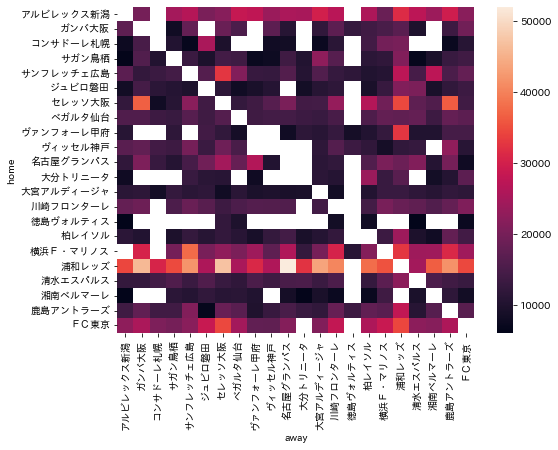

In [51]:
plt.figure(figsize=(8,6))
sns.heatmap(cb)

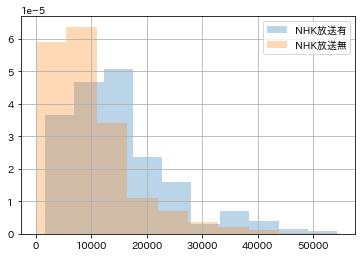

In [52]:
tmp = train.copy()
tmp['NHK'] = tmp['tv'].str.contains('ＮＨＫ')
tmp[tmp['NHK']==True]['y'].hist(density=True, alpha=0.3, label='NHK放送有')
tmp[tmp['NHK']==False]['y'].hist(density=True, alpha=0.3, label='NHK放送無')
plt.legend()


#### 節数で確かめてみる

<AxesSubplot:xlabel='match_num', ylabel='y'>

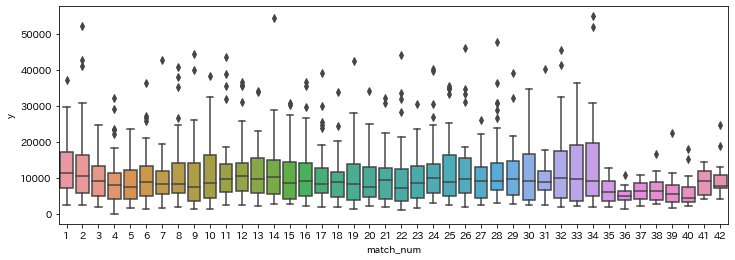

In [53]:
# 節数は「第」と「節」に挟まれている為、この文字をヒントに場所を指定
train["match_num"] = train["match"].apply(lambda x : int(x[x.find("第")+1:x.find("節")]))
plt.figure(figsize=(12,4))
sns.boxplot(x="match_num", y="y", data=train)

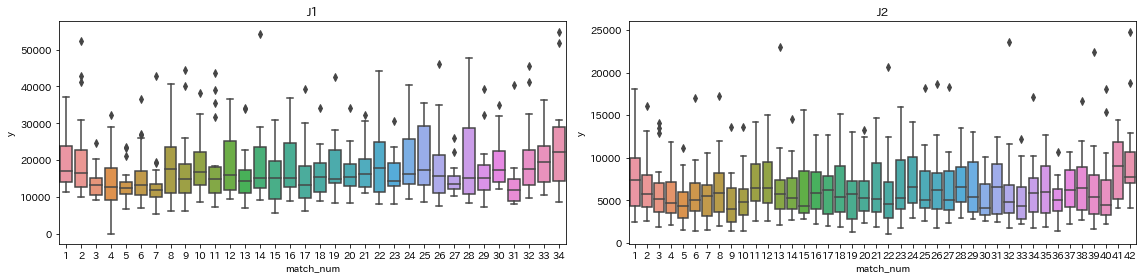

In [54]:
fig,ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(x="match_num", y="y", data=train[train["stage"]=="Ｊ１"], ax=ax[0])
ax[0].set_title("J1")
sns.boxplot(x="match_num", y="y", data=train[train["stage"]=="Ｊ２"], ax=ax[1])
ax[1].set_title("J2")
plt.tight_layout()

### 簡単なモデルを作って投稿してみる
- 単回帰モデルを使う

In [57]:
from sklearn.linear_model import LinearRegression as LR

In [58]:
train.head()

,id,y,year,stage,match,gameday,time,home,away,stadium,tv,match_num
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,1
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＮＨＫ名古屋,1
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）／ＮＨＫ大阪,1
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,スカパー／ｅ２／スカパー光／ＮＨＫ広島,1
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）／ＮＨＫ札幌,1


- yとtemperatureの単回帰モデルを作りたい
- train/condition及びtest/conditionを結合する必要がある
    - merge関数を使う
    - 具体的には、AとBをカラムXにて結合したい場合は、`pd.merge(A,B,on="X")`と記述する

In [59]:
train_merge = pd.merge(train, condition, on="id")
test_merge = pd.merge(test, condition, on="id")

In [60]:
train_merge.head(1)

,id,y,year,stage,match,gameday,time,home,away,stadium,...,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,...,新井場 徹,岩政 大樹,中田 浩二,アレックス,青木 剛,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ


In [61]:
train_merge.iloc[:, :15].head(3)

,id,y,year,stage,match,gameday,time,home,away,stadium,tv,match_num,home_score,away_score,weather
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,1,1,0,雨
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＮＨＫ名古屋,1,1,0,屋内
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）／ＮＨＫ大阪,1,2,3,晴一時雨


In [62]:
# 学習データから説明変数を抽出
trainX = train_merge[["temperature"]]

# 学習データから目的変数を抽出
y = train_merge["y"]

In [63]:
model = LR()
model.fit(trainX, y)

LinearRegression()

In [64]:
model.coef_ # 気温が上がるほど観客動員数は？

array([-29.98434917])

In [65]:
model.intercept_

11276.220568081866

In [66]:
# 評価データから説明変数を抽出
testX = test_merge[["temperature"]]

In [67]:
# 評価データへの予測
pred = model.predict(testX)
pred

array([10454.64940091, 10352.70261375, 10325.7166995 , 10397.6791375 ,
       10364.69635341, 10517.61653416, 10544.60244841, 10472.64001041,
       10583.58210233, 10553.59775316, 10544.60244841, 10517.61653416,
       10457.64783583, 10487.632185  , 10622.56175625, 10619.56332133,
       10544.60244841, 10613.5664515 , 10499.62592466, 10442.65566125,
       10472.64001041, 10493.62905483, 10499.62592466, 10457.64783583,
       10466.64314058, 10532.60870875, 10454.64940091, 10598.57427691,
       10547.60088333, 10448.65253108, 10484.63375008, 10508.62122941,
       10610.56801658, 10592.57740708, 10592.57740708, 10517.61653416,
       10508.62122941, 10586.58053725, 10529.61027383, 10484.63375008,
       10490.63061991, 10652.54610541, 10556.59618808, 10574.58679758,
       10556.59618808, 10583.58210233, 10529.61027383, 10574.58679758,
       10634.55549591, 10655.54454033, 10664.53984508, 10652.54610541,
       10589.57897216, 10592.57740708, 10718.51167358, 10778.48037191,
      

In [68]:
# 投稿用データの作成
sample.head()

,0,1
0,15822,10662.395119
1,15823,10662.395119
2,15824,10662.395119
3,15825,10662.395119
4,15827,10662.395119


In [69]:
sample[1] = pred
sample.head()

,0,1
0,15822,10454.649401
1,15823,10352.702614
2,15824,10325.716699
3,15825,10397.679137
4,15827,10364.696353


- 下記ファイルを書き出し、[コンペサイト](https://signate.jp/courses/VNeoDl9Mpg6YkBQL)に投稿しましょう

In [70]:
sample.to_csv("data/predict/submit1.csv", index=None, header=None)